# Neural ODE's

Given the vector quantity of interest $\mathbf{y}(t), t \in [0, T]$ we are considering a generic ODE of the shape:

$$
\frac{d\mathbf{y}(t)}{dt} = f(\mathbf{y}(t), t, \theta)
$$

where $f$ is a neural network with parameters $\theta$. Furthermore we have the true unknown function $f^*$, which we are trying to approximate. As in many machine learning problems, we have a dataset of observations $\mathbf{y}^*(t)$, $t \in [0, T]$ which we can use to train our model. We are interested in finding $\theta$ such that $\mathbf{y}(t)$ is close or equal to $\mathbf{y}^*(t)$, where $\mathbf{y}^*$ is the true solution of the ODE. Hence we can encode our task in a loss function

$$
\mathcal{L} = \sum_{t \in [0, T]} \left\| \mathbf{y}(t) - \mathbf{y}^*(t) \right\|^2
$$

which we wish to minimize using a gradient-based optimization algorithm such as Adam. The gradient (or Jacobian) is defined as

$$
\frac{\partial \mathcal{L}}{\partial \theta} = \sum_{t \in [0, T]} \frac{\partial \mathcal{L}}{\partial \mathbf{y}(t)} \frac{\partial \mathbf{y}(t)}{\partial \theta}
$$

where the first term is the gradient of the loss with respect to the output of the neural network, and the second term is the gradient of the output with respect to the parameters. Now before we go any further, let's use the power of automatic differentiation to directly compute the gradient of the loss with respect to the parameters.

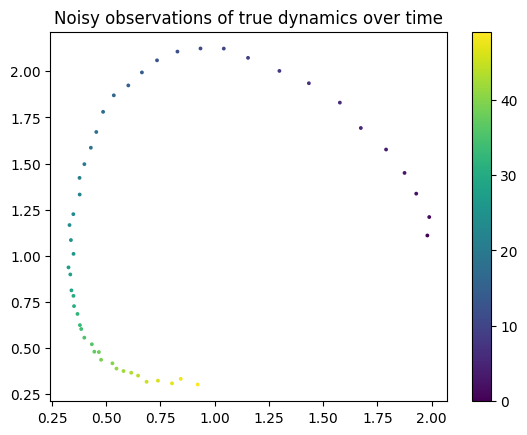

In [11]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

# random non linear dynamics
def f_star(y):
    return jnp.array([y[0] * (1 - y[1]), y[1] * (y[0] - 1)])

def solve_star(y_0, dt, n):
    y_hist = jnp.zeros((n, 2))
    y = y_0
    for i in range(n):
        y = f_star(y) * dt + y
        y_hist = y_hist.at[i, :].set(y)

    return y_hist

y_star_0 = jnp.array([2.0, 1.0])
dt = 0.1
n = 50
y_star = solve_star(y_star_0, dt, n)
noise = 0.01 * jax.random.normal(jax.random.PRNGKey(0), (n, 2))
y_star += noise

plt.scatter(y_star[:, 0], y_star[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()
plt.title("Noisy observations of true dynamics over time")
plt.show()

Hence we can formulate an objective function as the mean squared error between the true observation and the predicted observation

$$
\mathcal{L}(\theta) = \frac{1}{2} \left\| \mathbf{y}^*(T) - \mathbf{y}(T) \right\|^2
$$

where $\mathbf{y}(T, \theta)$ is the solution of the ODE with parameters $\theta$ at time $T$

$$
\mathbf{y}(T) = \mathbf{y}(0) + \int_0^T f(\mathbf{y}(t), t, \theta) dt
$$

## AD Gradient Computation

In a first attempt, we find the gradient of the solver with respect to the parameters $\theta$ by using AD as implemented in JAX.

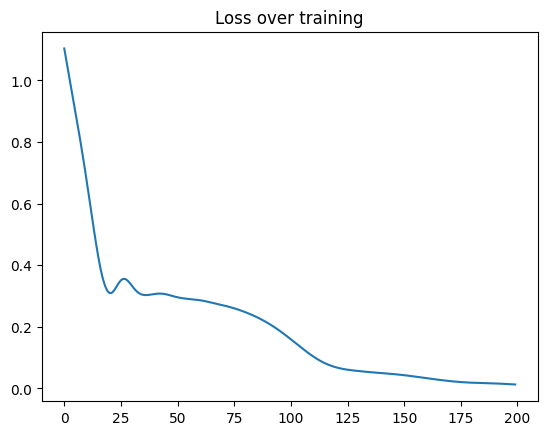

In [12]:
import optax
from typing import NamedTuple
from functools import partial

# we define the parameters of a simple MLP
class mlp_theta(NamedTuple):
    w0: jnp.ndarray
    b0: jnp.ndarray
    w1: jnp.ndarray
    b1: jnp.ndarray
    w2 : jnp.ndarray
    b2 : jnp.ndarray

def init_mlp(initializer):
    return mlp_theta(
        w0=initializer(jax.random.PRNGKey(0), (2, 8)),
        b0=jnp.zeros(8),
        w1=initializer(jax.random.PRNGKey(1), (8, 4)),
        b1=jnp.zeros(4),
        w2=initializer(jax.random.PRNGKey(2), (4, 2)),
        b2=jnp.zeros(2))

# we define the forward pass of the MLP
def f(y, theta: mlp_theta):
    y = y @ theta.w0 + theta.b0
    # we use a ReLU activation function, this is necessary to ensure that the model is able to learn non-linear functions
    y = jax.nn.relu(y)
    y = y @ theta.w1 + theta.b1
    y = jax.nn.relu(y)
    y = y @ theta.w2 + theta.b2
    return y

def solve(theta, y_0, dt, n):
    y_hist = jnp.zeros((n, 2))
    y = y_0
    for i in range(n):
        y = f(y, theta) * dt + y
        # this is special syntax required for JAX
        y_hist = y_hist.at[i, :].set(y)

    return y_hist

# we define the scalr loss function, MSE
def loss(y, y_star):
    return jnp.mean((y - y_star) ** 2)

# we define the solver and loss function
@partial(jax.jit, static_argnums=(3, 4))
def solve_and_loss(theta, y_0, y_star, dt, n):
    y = solve(theta, y_0, dt, n)
    return loss(y, y_star)

# In this case we assume that we know the initial condition
# In practice we might have to learn this as well
y_0 = y_star_0

# we compute the gradient of the loss with respect to theta
d_solve_loss = jax.value_and_grad(solve_and_loss, argnums=0)

# we initialize the parameters of the MLP
initializer = jax.nn.initializers.normal()
theta = init_mlp(initializer)

# we define the optimizer
optimizer = optax.adam(0.01)
optimizer_state = optimizer.init(theta)

loss_hist = []
# we train the model
for i in range(200):
    loss_value, grad = d_solve_loss(theta, y_0, y_star, dt, n)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    theta = optax.apply_updates(theta, updates)
    loss_hist.append(loss_value)

plt.plot(loss_hist)
plt.title("Loss over training") 
plt.show()

Lets check how this compares to the observation $\mathbf{y}^*(t)$.

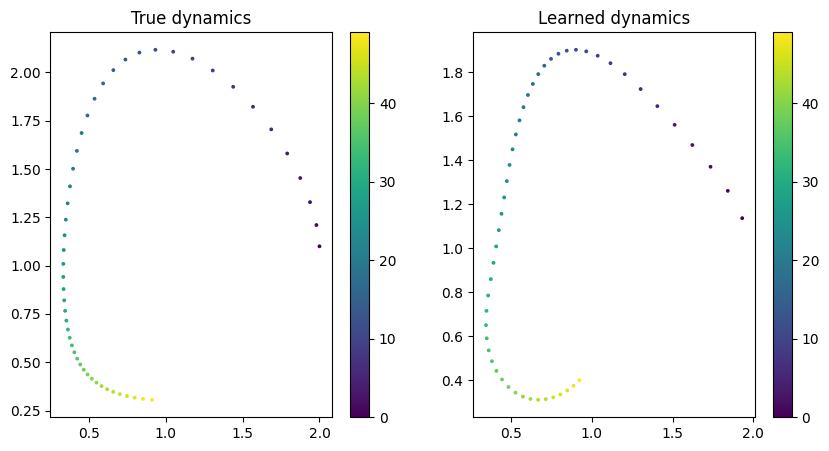

In [13]:
n = 50

y = solve(theta, y_0, dt, n)
y_star = solve_star(y_star_0, dt, n)

# side by side comparison of the true dynamics and the learned dynamics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("True dynamics")
plt.scatter(y_star[:, 0], y_star[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Learned dynamics")
plt.scatter(y[:, 0], y[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()
plt.show()

The results look promising, but its clear that the function is not equivalent. This becomes more clear when we plot the same but for more time steps.

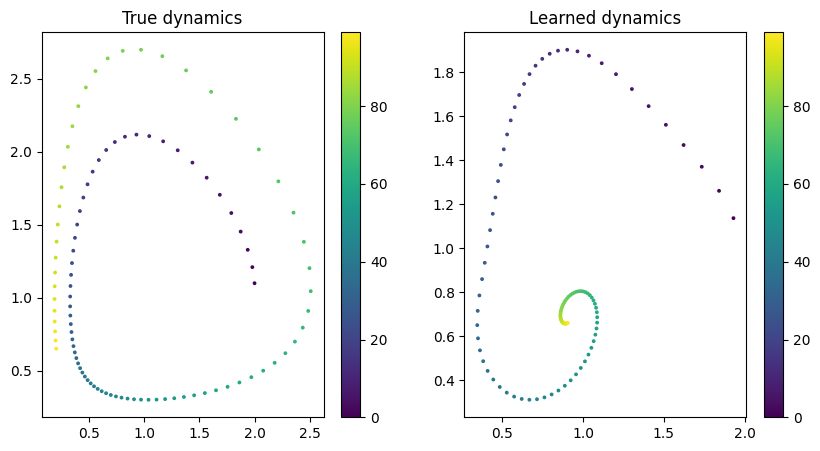

In [14]:
n = 100

y = solve(theta, y_0, dt, n)
y_star = solve_star(y_star_0, dt, n)

# side by side comparison of the true dynamics and the learned dynamics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("True dynamics")
plt.scatter(y_star[:, 0], y_star[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Learned dynamics")
plt.scatter(y[:, 0], y[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()
plt.show()

Now before we try to optimzie the above code to get better results there are severel things that are very suboptimal in the above code. For one we have a for loop inside the ode solver, which is something we should always be careful with when using Automatic differentation. Let us dive a bit deeper into the neural ODE paper. 

## Adjoint Method

Let us revisit the equation 

$$
\frac{d \mathcal{L}}{d \theta} = \sum_{t \in [0, T]} \frac{\partial \mathcal{L}}{\partial \mathbf{y}(t)} \frac{\partial \mathbf{y}(t)}{\partial \theta}
$$

we can define the adjoint as 

$$
\mathbf{a}(t) = \frac{\partial \mathcal{L}}{\partial \mathbf{y}(t)}
$$

and the adjoint ODE as

$$
\frac{d\mathbf{a}(t)}{dt} = -\frac{\partial f(\mathbf{y}(t), t, \theta)}{\partial \mathbf{y}}^T \mathbf{a}(t)
$$

which can be solved using the same ODE solver as before. The gradient can then be computed as

$$
\frac{\partial \mathcal{L}}{\partial \theta} = -\int_0^T \frac{\partial f(\mathbf{y}(t), t, \theta)}{\partial \theta}^T \mathbf{a}(t) dt
$$

In [25]:
# first we compute the entire forward trajectory
ys = solve(theta, y_0, dt, n)

# we then compute gradient backwards
def backwards(ys, theta):

    initializer = jax.nn.initializers.zeros
    adjoint = init_mlp(initializer)

    # iterate over fields of adjoint namedtuple and set first entry to 1 -> [1, 0, ...]
    adjoint = adjoint._replace(w0=adjoint.w0.at[0].set(1.0))
    adjoint = adjoint._replace(b0=adjoint.b0.at[0].set(1.0))
    adjoint = adjoint._replace(w1=adjoint.w1.at[0].set(1.0))
    adjoint = adjoint._replace(b1=adjoint.b1.at[0].set(1.0))
    adjoint = adjoint._replace(w2=adjoint.w2.at[0].set(1.0))
    adjoint = adjoint._replace(b2=adjoint.b2.at[0].set(1.0))

    for i in range(n-1, 0, -1):
        df_dy = jax.jacobian(f, 1)(ys[i], theta)
        print(df_dy)
        print(adjoint.w0.shape)
        print(df_dy.w0.shape)
        adjoint = adjoint._replace(w0=adjoint.w0 + dt * adjoint.w0 @ df_dy.w0)
        adjoint = adjoint._replace(b0=adjoint.b0 + dt * adjoint.b0 @ df_dy.b0)
        adjoint = adjoint._replace(w1=adjoint.w1 + dt * adjoint.w1 @ df_dy.w1)
        adjoint = adjoint._replace(b1=adjoint.b1 + dt * adjoint.b1 @ df_dy.b1)
        adjoint = adjoint._replace(w2=adjoint.w2 + dt * adjoint.w2 @ df_dy.w2)
        adjoint = adjoint._replace(b2=adjoint.b2 + dt * adjoint.b2 @ df_dy.b2)

backwards(ys, theta)


TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).